# I. Import Librairies

In [1]:
# Import needed librairies

import pandas as pd
import numpy as np

# Data engineering 
#!pip install textblob
from textblob import TextBlob
import traceback
import string
import sys
from time import time

# Data processing
#!pip install gensim
import re
import pickle
import traceback
import numpy as np
from gensim import parsing
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Autoencoder and Classification
import tensorflow as tf
from tensorflow.keras import layers, backend
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import gridspec
%matplotlib inline


# II. Load Data

In [2]:
Occupation_Data = pd.read_excel('PATH')
Abilities = pd.read_excel('PATH')
Skills = pd.read_excel('PATH')
Technology_Skills = pd.read_excel('PATH')
Tools_Used = pd.read_excel('PATH')
Work_Context = pd.read_excel('PATH')
Work_Styles = pd.read_excel('PATH')

#### - Extract Job titles and descriptions

In [16]:
df = []
df = Occupation_Data[["O*NET-SOC Code", "Description", "Title"]]
df = df.rename(columns={"O*NET-SOC Code": "job_id"})
df = df.drop_duplicates()

print ("Nb of different jobs : ", df.shape)
df.head()

Nb of different jobs :  (1110, 3)


,job_id,Description,Title
0,11-1011.00,Determine and formulate policies and provide o...,Chief Executives
1,11-1011.03,"Communicate and coordinate with management, sh...",Chief Sustainability Officers
2,11-1021.00,"Plan, direct, or coordinate the operations of ...",General and Operations Managers
3,11-1031.00,"Develop, introduce or enact laws and statutes ...",Legislators
4,11-2011.00,"Plan, direct, or coordinate advertising polici...",Advertising and Promotions Managers


#### - Extract needed columns from all files

In [17]:

Abilities_2 = Abilities[["Title", "Element Name"]]
Abilities_2 = Abilities_2.rename(columns={"Element Name": "Skill"})

Skills_2 = Skills[["Title", "Element Name"]]
Skills_2 = Skills_2.rename(columns={"Element Name": "Skill"})

Technology_Skills_2 = Technology_Skills[["Title", "Example"]]
Technology_Skills_2 = Technology_Skills_2.rename(columns={"Example": "Skill"})

Tools_Used_2 = Tools_Used[["Title", "Example"]]
Tools_Used_2 = Tools_Used_2.rename(columns={"Example": "Skill"})

Work_Context_2 = Work_Context[["Title", "Element Name"]]
Work_Context_2 = Work_Context_2.rename(columns={"Element Name": "Skill"})

Work_Styles_2 = Work_Styles[["Title", "Element Name"]]
Work_Styles_2 = Work_Styles_2.rename(columns={"Element Name": "Skill"})


### - Create one unified datafram "job_data"

In [29]:
df_2 = pd.concat([Abilities_2, Skills_2, Technology_Skills_2, Tools_Used_2, Work_Context_2, Work_Styles_2])
df_2 = df_2.drop_duplicates()
df_2.reset_index(inplace =True, drop = True)

job_data = []

job_data = pd.merge(df, df_2)
data_file = "Dataset/job_data.csv"
job_data.to_csv(data_file, index=False)

print("Nb or rows : ", job_data.shape)
job_data.head()

Nb or rows :  (226493, 4)


,job_id,Description,Title,Skill
0,11-1011.00,Determine and formulate policies and provide o...,Chief Executives,Oral Comprehension
1,11-1011.00,Determine and formulate policies and provide o...,Chief Executives,Written Comprehension
2,11-1011.00,Determine and formulate policies and provide o...,Chief Executives,Oral Expression
3,11-1011.00,Determine and formulate policies and provide o...,Chief Executives,Written Expression
4,11-1011.00,Determine and formulate policies and provide o...,Chief Executives,Fluency of Ideas


## III. Data Collection, Engineering and Processing

In the following we define multiple functions for data management

### III.1 Data Collection
####  - Remove Unwanted Data
Cleaning our data before feature engineering

In [30]:

def data_collection(data_file):
    df = pd.read_csv(data_file)
    try:
        # remove empty title/descriptions
        df['Description'].replace('', np.nan, inplace=True)
        df['Title'].replace('', np.nan, inplace=True)
        df.dropna(subset=['Description'], inplace=True)
        df.dropna(subset=['Title'], inplace=True)
    except:
        print("ERROR: Unable to remove unwanted rows from the dataframe")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    return df


### III.2 Feature Engineering

Collection of feature engineering functions that takes
creates features and prepares our data for the AI model

In [31]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
             'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
             'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
             'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about',
             'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in',
             'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
             'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',
             'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
             'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
             "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
             "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


# Count Text Features: character count, word count, word density, punctuation count, uppercase word count, stop word count
def text_features(df):
    punctuation = string.punctuation
    df['char_count'] = df.Description.apply(len)
    df['word_count'] = df.Description.apply(lambda x: len(x.split()))
    df['word_density'] = df['char_count'] / (df['word_count'] + 1)
    df['punctuation_count'] = df.Description.apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
    df['upper_case_word_count'] = df.Description.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['stopword_count'] = df.Description.apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stopwords]))
    return df

def pos_check(text, flag):
    pos_dic = {'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
               'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
               'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
               'adj':  ['JJ', 'JJR', 'JJS'],
               'adv': ['RB', 'RBR', 'RBS', 'WRB']}
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tupple in wiki.tags:
            part_of_speech = list(tupple)[1]
            if part_of_speech in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Count different types of words in a job description
def word_selection_features(df):
    df['noun_count'] = df.Description.apply(lambda x: pos_check(x, 'noun'))
    df['verb_count'] = df.Description.apply(lambda x: pos_check(x, 'verb'))
    df['adj_count'] = df.Description.apply(lambda x: pos_check(x, 'adj'))
    df['adv_count'] = df.Description.apply(lambda x: pos_check(x, 'adv'))
    df['pron_count'] = df.Description.apply(lambda x: pos_check(x, 'pron'))
    return df

def pos_features(df):
    try:
        # Find numerical data from text i.e. number of stopwords
        text_data_df = text_features(df)
    except:
        print("ERROR: Unable to create numerical text features from the data")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)

    try:
        # Find part of speech data from text i.e. number of verbs
        text_data_df = word_selection_features(df)
    except:
        print("ERROR: Unable to create part of speech features from the data")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    # return data
    return text_data_df


# Data Handeling: Append each job id's tag into one row
def aggregate_job_tag_rows(df):
    # make place holder column
    df['job_targets'] = "N/A"
    # for each job id add every job skill that is listed for it across the rows
    for id in set(df.job_id):
        group = df.loc[df['job_id'] == id]
        target = group.Skill.values
        df.at[group.index[0], 'job_targets'] = target.tolist()
    # get rid of all repeated job ids
    df = df[df.job_targets != "N/A"]
    # get rid of the Skill column
    df = df.drop(['Skill'], axis=1)
    return df

# The main function for feature engineering
def feature_engineering(df):
    text_data_df = pos_features(df)
    try:
        df2 = aggregate_job_tag_rows(text_data_df)
    except:
        print("ERROR: Unable to consoladate job tags")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    return df2


### III.3 Feature Processing
Collection of data processing functions that takes our features converts them into numbers using feature hashing

In [66]:
cList = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have",
         "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
         "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
         "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
         "it'd": "it had", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
         "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have",
         "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
         "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
         "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there had",
         "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
         "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had",
         "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
         "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
         "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
         "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
         "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
         "y'all": "you all", "y'alls": "you alls", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
         "y'all've": "you all have", "you'd": "you had", "you'd've": "you would have", "you'll": "you you will", "you'll've": "you you will have",
         "you're": "you are", "you've": "you have"}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))


def remove_web_text(html):
    # create a new bs4 object from the html data loaded
    soup = BeautifulSoup(html, features="html.parser")
    for script in soup(["script", "style"]):  # remove all javascript and stylesheet code
        script.extract()
    text = soup.get_text()     # get text
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))  # break multi-headlines into a line each
    text = '\n'.join(chunk for chunk in chunks if chunk)    # drop blank lines
    return text


def expandcontractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

# Remove any html or css code Replace any leftover arrows Replace any new line symbols
def clean_text(df):
    # parse html
    df.Description = [remove_web_text(text) for text in df.Description]
    # remove tags by regex
    df.Description = df.Description.str.replace('<[^>]+>', '')
    # repalce \r\n with a space
    df.Description = df.Description.str.replace("\r\n", ' ')
    return df

# Expand contractions, make text lowercase, remove punctuation, remove any digits, remove stop words
def strip_text(df):
    # expand contractions
    df.Description = [expandcontractions(text) for text in df.Description]
    # make lowercase
    df.Description = [text.lower() for text in df.Description]
    df.Title = [text.lower() for text in df.Title]
    # remove punctuation
    df.Description = df.Description.str.replace('[^\w\s]', '')
    df.Title = df.Title.str.replace('[^\w\s]', '')
    # remove digits
    df.Description = df.Description.str.replace('\d+', '')
    # remove stopwords
    pat = r'\b(?:{})\b'.format('|'.join(stopwords))
    df.Description = df.Description.str.replace(pat, '')
    return df

# Stem text by reducing a word to its root form ex : requires->require 
def stem_text(df):
    def stem_sentences(sentence):
        tokens = sentence.split()
        stemmed_tokens = [parsing.stem_text(token) for token in tokens]
        return ' '.join(stemmed_tokens)
    df.Description = df.Description.apply(stem_sentences)
    return df

# Scale the values of text features
###### I WAS OBLIGED TO ADD : 'noun_count'
def scale_pos_features(df):
    try:
        # seperate text feature numerical values
        text_df = df[['char_count', 'word_count', 'word_density', 'punctuation_count', 'upper_case_word_count', 'stopword_count', 'noun_count']]
        text_feature_matrix = text_df.values # matrix of values only
        # scale text feature matrix
        scaler = MinMaxScaler() # feature_range=(0, 1)
        text_feature_matrix = scaler.fit_transform(text_feature_matrix)
    except:
        print("ERROR: Unable to scale the text features")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    return text_feature_matrix

# Turns Descriptions and Titles into token occurrence counts by hashing. finds the token string name to feature integer index mapping
def hash_trick(df):
    def hash(text, num_words):
        vectorizer = HashingVectorizer(n_features=num_words, alternate_sign=False)
        return vectorizer.fit_transform(text).todense()
    try:
        # use hashing trick to allow new words to automatically be used in future data
        # the length of the hash table must be fixed throught training and predicition
        # if you want to change the length you must re train the model again
        # Collisions can be avoided using larger sized arrays but for now...
        description_matrix = hash(df.Description, pow(2, 14))
        title_matrix = hash(df.Title, pow(2, 11) - 7)
    except:
        print("ERROR: Unable to convert text with hashing trick")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    # return the data
    return description_matrix, title_matrix

# Combine the text data, the part of speech data, and the text features into one dataframe
def collect_dataframes(matrix_1, matrix_2, matrix_3):
    # research locals().keys() and open ended arguments
    try:
        x = np.hstack((matrix_1, matrix_2, matrix_3)) # stack the sequence of input arrays horizontally 
    except:
        print("ERROR: Unable to stack all of the matricies")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    return x

# Encode the job_targets 
def target_encoder(df):
    try:
        # create job target encoder
        labeler = MultiLabelBinarizer() # encode multiple labels per instance
        y = labeler.fit_transform(df.job_targets)
        # save target corpus
        with open("Models/Tokenizers/target_tokens.pkl", 'wb') as vocab_file:
            pickle.dump(labeler, vocab_file, protocol=pickle.HIGHEST_PROTOCOL)
    except:
        print("ERROR: Unable to one-hot-encode target")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    return y

 # The main function for feature processing
def feature_processing(df):

    try:
        df = clean_text(df)
        df = strip_text(df)
        df = stem_text(df)
    except:
        print("ERROR: Unable to preprocess text into desired format")
        traceback.print_exc(file=sys.stdout)
        sys.exit(0)
    agg_file = "Dataset/agg_file.csv"
    df.to_csv(agg_file, index=False)
    text_feature_matrix = scale_pos_features(df) #Scale the values of text features
    description_matrix, title_matrix = hash_trick(df) #Hash Titles and Descriptions

    x = collect_dataframes(description_matrix, title_matrix, text_feature_matrix) #Combine all in one matrix to obtain input matrix
    y = target_encoder(df) # the output encoded

    return x, y 


### III.4 A Pipelne for data management

In [67]:
def DataLoader(data_file, test_size):

    print("Starting Data Collection")
    df = data_collection(data_file)  # collect the data

    print("Starting Feature Engineering")
    df2 = feature_engineering(df)  # create some text features

    print("Starting Feature Processing")
    x, y = feature_processing(df2)  # convert the text into numbers for processing

    print("Data Loading Compelete")
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=test_size, random_state=42)  # validation

    return X_train, X_test, Y_train, Y_test

## IV. Modeling
In this stage, we provide our models the we will use to predict Job Tags. We start with an Autoencoder model then wi a Deep Neural Network.

### IV.1 Autoencoder
We first trained an autoencoder to reduce the dimensionality of our input data (X) to 100 columns (Dimension reduction). We train a convolutional Autoencoder with 4 convolution/pooling steps and 3 hidden layers that is symmetric around the center of the network. The input to the network is the same as the output of the network. 
This way our network is trained to learn a representation of the data. This essentially compresses the data with some losses. 

In [68]:
X_train, X_test, _, _ = DataLoader(data_file, test_size=.25)
print(X_train.shape)
print(X_test.shape)
# reshape data to fit into our model
num_varibles = X_train.shape[1]
print(num_varibles)

Starting Data Collection
Starting Feature Engineering
Starting Feature Processing
Data Loading Compelete
(730, 18432)
(244, 18432)
18432


In [39]:
def model(num_varibles):

    input = layers.Input(shape=(num_varibles,))
    reshape = layers.Reshape((num_varibles, 1))(input)

    conv = layers.Conv1D(100, 10, padding='same')(reshape)
    pool = layers.MaxPooling1D(2, padding='same')(conv)
    conv = layers.Conv1D(80, 8, padding='same')(pool)
    pool = layers.MaxPooling1D(2, padding='same')(conv)
    conv = layers.Conv1D(60, 6, padding='same')(pool)
    pool = layers.MaxPooling1D(2, padding='same')(conv)
    conv = layers.Conv1D(40, 4, padding='same')(pool)
    pool = layers.MaxPooling1D(2, padding='same')(conv)
    conv = layers.Conv1D(10, 2, padding='same')(pool)
    pool = layers.MaxPooling1D(2, padding='same')(conv)

    flatten = layers.Flatten()(pool)

    dense = layers.Dense(300, activation="relu")(flatten)
    dense = layers.Dense(200, activation="relu")(dense)
    encoded = layers.Dense(100, activation="relu")(dense)
    dense = layers.Dense(200, activation="relu")(encoded)
    dense = layers.Dense(300, activation="relu")(dense)

    dense = layers.Dense(5760)(dense)
    reshape = layers.Reshape((int(5760/10), 10))(dense)


    conv = layers.Conv1D(10, 2, padding='same')(reshape)
    upsample = layers.UpSampling1D(2)(conv)
    conv = layers.Conv1D(40, 4, padding='same')(upsample)
    upsample = layers.UpSampling1D(2)(conv)
    conv = layers.Conv1D(60, 6, padding='same')(upsample)
    upsample = layers.UpSampling1D(2)(conv)
    conv = layers.Conv1D(80, 8, padding='same')(upsample)
    upsample = layers.UpSampling1D(2)(conv)
    conv = layers.Conv1D(100, 10, padding='same')(upsample)
    upsample = layers.UpSampling1D(2)(conv)
    conv = layers.Conv1D(1, 250, padding='same')(upsample)

    output = layers.Flatten()(conv)

    autoencoder = Model(inputs=input, outputs=output, name='Autoencoder')
    encoder = Model(inputs=input, outputs=encoded, name='Encoder')
    autoencoder.compile(optimizer='adam', loss='mse')
    encoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

# After we train the autoencoder on our dataset we can then cut off the decoder and use the encoder as the first step in our model :

# grab the network
autoencoder, encoder = model(num_varibles)
autoencoder.summary()

# fit the autoencoder
autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=5, batch_size=10, verbose=1)

# save the encoder half
model = encoder.save("Models/encoder_model")



Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 18432, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 18432, 100)        1100      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9216, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9216, 80)          64080     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4608, 80)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4608, 60)          

### IV.2 Deep Neural Network
The Autoencoder is trained. We will used to predict data encoded that will be used in Deep Neural Network.
Next, we use a Deep Neural Network with 5 hidden layers :

Input->200->150->100->50->25->Output.

In [69]:
X_train, X_test, Y_train, Y_test = DataLoader(data_file, test_size=.2)

Starting Data Collection
Starting Feature Engineering
Starting Feature Processing
Data Loading Compelete


In [43]:
# open channel for TensorBoard
tensorboard = TensorBoard(log_dir="Logs/classifier/{}".format(time()),
                          histogram_freq=1,
                          write_grads=True)

def classification_model(num_varibles, num_classes):
    # create model
    input = layers.Input(shape=(num_varibles, ))
    dense = layers.Dense(200, activation='relu')(input)
    dense = layers.Dropout(.2)(dense)
    dense = layers.Dense(150, activation='relu')(dense)
    dense = layers.Dropout(.2)(dense)
    dense = layers.Dense(100, activation='relu')(dense)
    dense = layers.Dropout(.2)(dense)
    dense = layers.Dense(50, activation='relu')(dense)
    dense = layers.Dropout(.2)(dense)
    dense = layers.Dense(25, activation='relu')(dense)
    dense = layers.Dropout(.2)(dense)
    output = layers.Dense(num_classes, activation='sigmoid')(dense)

    classifier = Model(inputs=input, outputs=output, name='Classifier')
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier


# encode the Input
#encoder = models.load_model("Models/encoder_model")
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# build the model
num_varibles = X_train_encoded.shape[1]
num_classes = Y_train.shape[1]
classifier = classification_model(num_varibles, num_classes)

# fit the model
classifier.fit(X_train_encoded, Y_train, validation_data=(X_test_encoded, Y_test), epochs=50, batch_size=5, callbacks=[tensorboard])

# evaluate the model
loss, accuracy = classifier.evaluate(X_test_encoded, Y_test, verbose=0)

# save the model
classifier.save("Models/classifier_model")


Train on 779 samples, validate on 195 samples
Epoch 1/50
779/779 [==============================] - 2s 2ms/sample - loss: 0.1860 - accuracy: 0.9941 - val_loss: 0.0163 - val_accuracy: 0.9974
Epoch 2/50
779/779 [==============================] - 1s 2ms/sample - loss: 0.0182 - accuracy: 0.9973 - val_loss: 0.0166 - val_accuracy: 0.9974
Epoch 3/50
779/779 [==============================] - 1s 2ms/sample - loss: 0.0178 - accuracy: 0.9973 - val_loss: 0.0173 - val_accuracy: 0.9975
Epoch 4/50
779/779 [==============================] - 1s 2ms/sample - loss: 0.0179 - accuracy: 0.9973 - val_loss: 0.0176 - val_accuracy: 0.9975
Epoch 5/50
779/779 [==============================] - 1s 2ms/sample - loss: 0.0175 - accuracy: 0.9973 - val_loss: 0.0177 - val_accuracy: 0.9975
Epoch 6/50
779/779 [==============================] - 1s 1ms/sample - loss: 0.0175 - accuracy: 0.9973 - val_loss: 0.0180 - val_accuracy: 0.9974
Epoch 7/50
779/779 [==============================] - 1s 1ms/sample - loss: 0.0172 - accur

### IV.3 Predictions and evaluations
Now we make some predictions to test the model. 

####DELETE

First let's extract some data from original dataset for  prediction.

Then we prepare our Prediction dataset *job_data_pred* to inject it into our model.

In [122]:
Y_pred = classifier.predict(X_test_encoded)

In [123]:
#Let's see how our model performed
print('Accuracy = ', (accuracy*100), '%')

Accuracy =  99.74528551101685 %


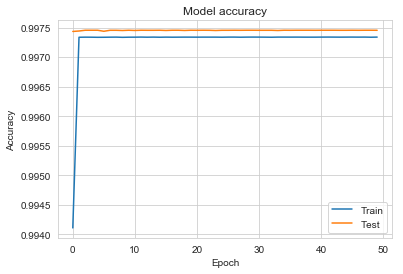

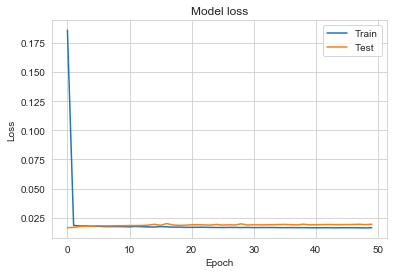

In [234]:
# Evaluation

# Plot history for accuracy

plt.plot(classifier.history.history['accuracy'])
plt.plot(classifier.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot history for loss

plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [211]:
with open("Models/Tokenizers/target_tokens.pkl", 'rb') as handle:
        tokenizer = pickle.load(handle)
target = []
for j in range(195):
    target2 = []
    for i, num in enumerate(Y_pred[j]):
        if num > threshold:
           target2.append(str(tokenizer.classes_[i]))
    target.append(target2)


In [238]:
agg_file = "Dataset/agg_file.csv"
agg_data = pd.read_csv(agg_file)
agg_sub = agg_data[["Description", "Title", "job_targets"]]
agg_sub_slice = agg_sub.loc[1:20,]

data_sub = "Dataset/agg_sub_slice.csv"
agg_sub_slice.to_csv(data_sub, index=False)